## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from tqdm.auto import tqdm

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver

from qiskit.converters import circuit_to_dag, dag_to_circuit

# Basic Demo and debugging of the xQAOA solver. 

## Problem Setup and Classical Solutions

To begine we initialize our hard knapsack distribution, including the capacity constraint. We end with a plot of all the items in the knapsack and their values and weights.

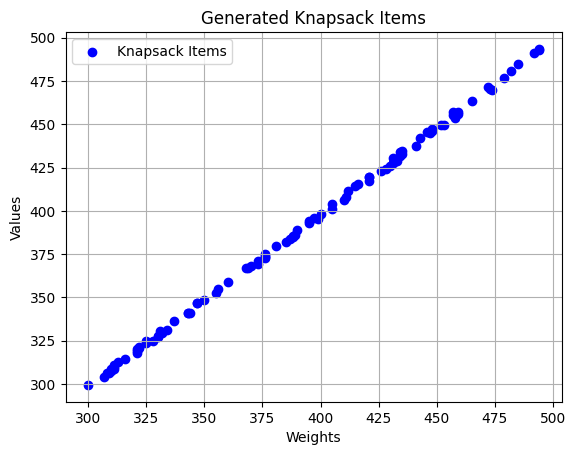

In [2]:
from collections import Counter

n = 100  # Number of items
frac = 0.3 # Fraction of total weight to set as capacity

def generate_random_ratio(n, ratio_range = 0.005):
    weights = np.random.randint(300, 500, n)
    ratios = np.random.uniform(1- ratio_range, 1, n)
    values = weights * ratios
    return weights, values

[weights,values] = generate_random_ratio(n, ratio_range=0.01) # create the list of knapsack items

capacity = frac * np.sum(weights)  # Set weight limit to some % of total weight

# Plot the knapsack items
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Let's try this other random hard instance

In [54]:
values=np.array([5000100215, 5000100090, 5000100237, 5000100245, 5000100207,
       5000100166, 5000100089, 5000100254, 5000100066, 5000100296,
       5000100118, 5000100187, 5000100114, 5000100115, 5000100248,
       5000100087, 5000100273, 5000100054, 5000100286, 5000100216,
       5000100041, 5000100183, 5000100041, 5000100064, 5000100082,
       5000100008, 5000100164, 5000100034, 5000100033, 5000100031,
       5000100127, 5000100251, 5000100050, 5000100160, 5000100200,
       2500100104, 2500100230, 2500100177, 2500100160, 2500100010,
       2500100041, 2500100056, 2500100267, 2500100093, 2500100234,
       2500100178, 2500100164, 2500100264, 2500100257, 2500100261,
       2500100099, 2500100052, 2500100165, 2500100113, 2500100103,
       2500100287, 2500100231, 2500100022, 2500100277, 2500100083,
       2500100254, 2500100072, 2500100140, 2500100216, 2500100160,
       2500100066, 2500100033, 2500100191, 2500100278, 2500100219,
               39,        188,        222,         27,        220,
              158,         66,        259,        139,          1,
               15,        194,        180,        134,        142,
              104,        245,        284,        294,         14,
              189,         20,         99,        275,        190,
              248,         29,         92,        270,         15])
frac=0.038
weights=np.array([5000100106, 5000100056, 5000100027, 5000100139, 5000100257,
       5000100027, 5000100033, 5000100071, 5000100157, 5000100273,
       5000100224, 5000100294, 5000100048, 5000100134, 5000100213,
       5000100051, 5000100256, 5000100005, 5000100039, 5000100128,
       5000100128, 5000100271, 5000100289, 5000100066, 5000100270,
       5000100283, 5000100201, 5000100021, 5000100239, 5000100011,
       5000100232, 5000100172, 5000100110, 5000100131, 5000100220,
       2500100257, 2500100081, 2500100048, 2500100128, 2500100021,
       2500100261, 2500100059, 2500100094, 2500100218, 2500100083,
       2500100252, 2500100073, 2500100119, 2500100029, 2500100233,
       2500100143, 2500100050, 2500100138, 2500100232, 2500100224,
       2500100055, 2500100058, 2500100163, 2500100201, 2500100207,
       2500100028, 2500100222, 2500100079, 2500100162, 2500100253,
       2500100082, 2500100203, 2500100216, 2500100100, 2500100211,
              133,        245,        134,        297,        204,
              124,        298,        154,         59,        267,
               18,        295,         35,        198,        223,
              182,         66,        283,         51,        280,
              105,         11,          7,        195,        234,
               42,         52,        163,         10,        248])
capacity = frac * np.sum(weights)  

Note the relationship between item weights and value is essentially linear with value equal to the weight rounded down to the nearest multiple of $d$. 

A useful way to visualize this is to plot the ratio of value/weight against the weights. 

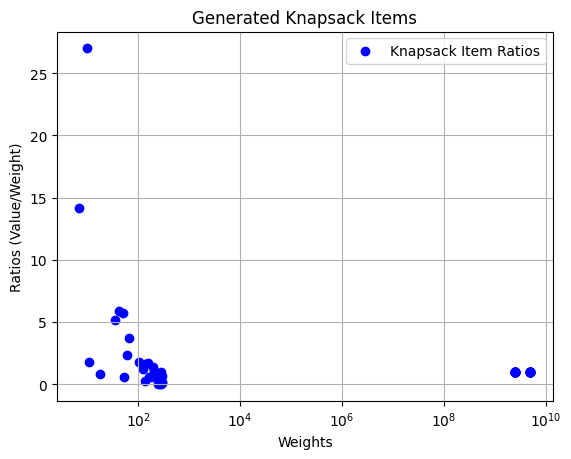

In [58]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.xscale('log')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now lets solve the problem with Gurobi and plot the optimal solution.

Knapsack Capacity: 9975266561.564
Total Value of optimal solution: 7500305184
Total Weight of optimal solution: 7500304862
Runtime: 0.007630 seconds


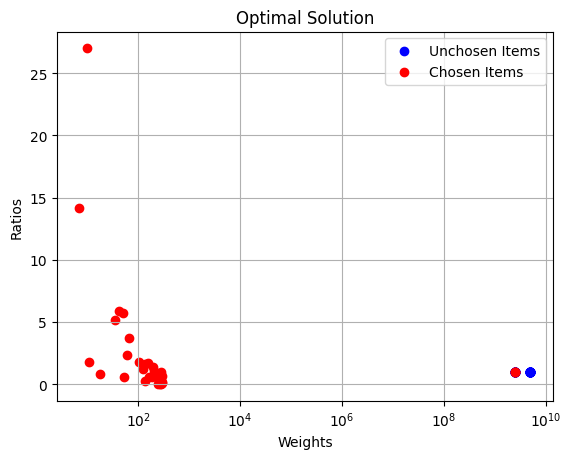

In [59]:
# Solve the knapsack problem using Gurobi
result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 7500305150
Greedy Solution Weight: 7500304725


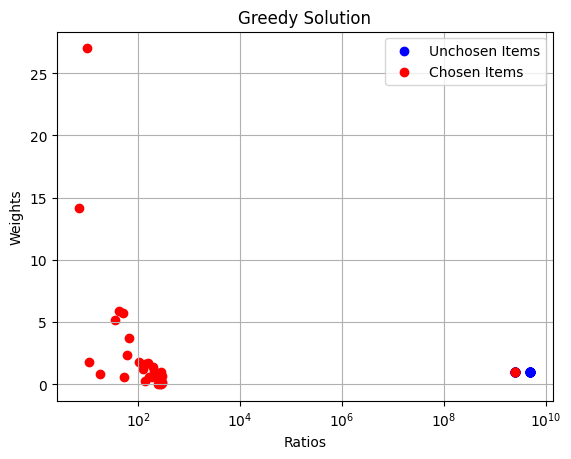

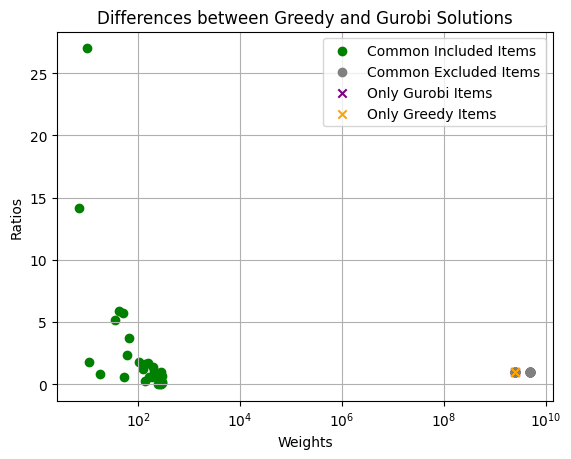

Gurobi solution obtains a value 34.0000 above the greedy solution.
This corresponds to greedy being a fraction 0.0000 off optimal.


In [61]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.xscale('log')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()

print(f"Gurobi solution obtains a value {optimal_value - greedy_value:.4f} above the greedy solution.")
print(f"This corresponds to greedy being a fraction {(optimal_value - greedy_value)/optimal_value:.4f} off optimal.")


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

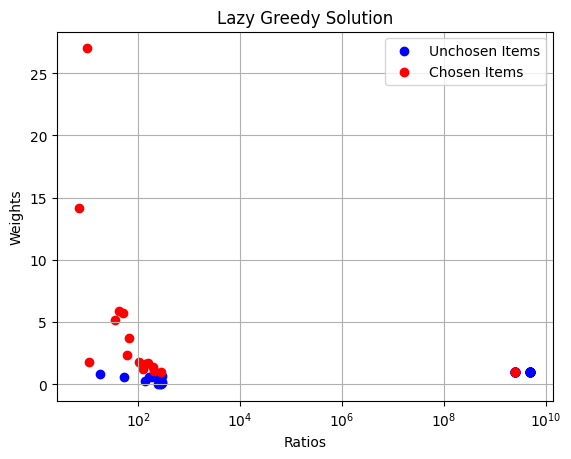

In [62]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



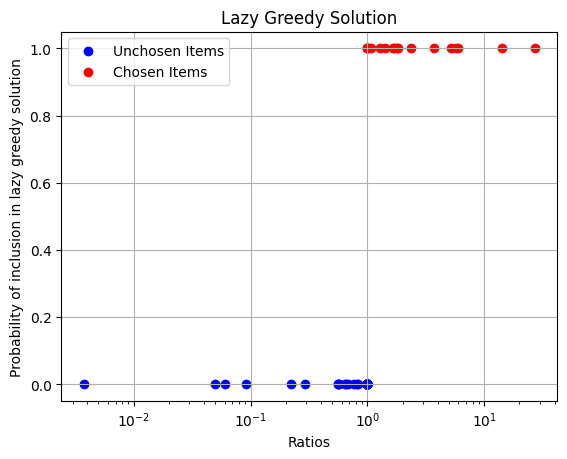

In [63]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.legend()
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k. Setting k = infinity produces the lazy greedy distribution above, while setting k = 0 produces a uniform distribution with expected weight equal to the capacity of knapsack. 

/var/folders/6p/67gfm43s19b12128lxx6vlzm0000gn/T/ipykernel_49084/3031079104.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))
/var/folders/6p/67gfm43s19b12128lxx6vlzm0000gn/T/ipykernel_49084/3031079104.py:8: RuntimeWarning: overflow encountered in multiply
  return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))


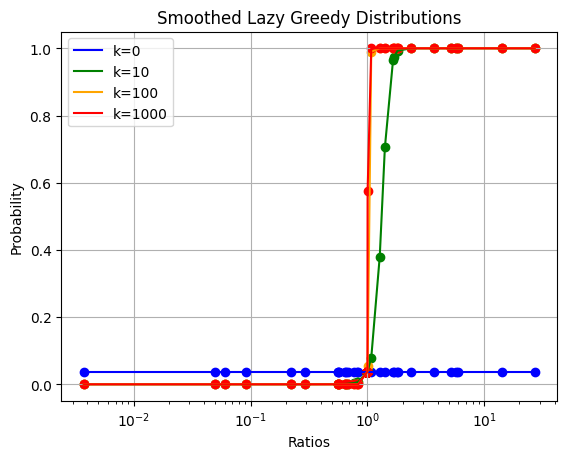

In [64]:
def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    # First find the cutoff ratio for the lazy greedy solution.
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, values / weights, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution]) 
    # Then set some constants so that in the limit of k = 0 we have the correct uniform distribution.
    uniform_probability = np.sum(weights) / capacity

    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

# Lets plot some solutions for different values of k
k_values = [0, 10, 100, 1000]
colours = ['blue', 'green', 'orange', 'red']
plt.figure()
for i in range(len(k_values)):
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_values[i])
    plt.scatter(ratios, smoothed_distribution, color=colours[i], marker='o')
    # plot a line through the points
    ordered_indices = np.argsort(ratios)
    plt.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices], color=colours[i], label=f'k={k_values[i]}')
plt.title('Smoothed Lazy Greedy Distributions')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


Note that our "solution" is now a probability distribution. We can repeatedly sample from this distribution to understand the quality of the solutions our warm start gives. An important observation is that this distribution will sometimes give solutions which do not respect the capacity restraints of thte knapsack. We must filter those out to get an accurate understanding of the solution quality.  

Best valid solution value is: 7500302357
Worst invalid solution is: 10000200945
Optimal solution value is: 7500305194
Probability of valid samples: 0.448
Approximation ratio of valid samples: 0.6369


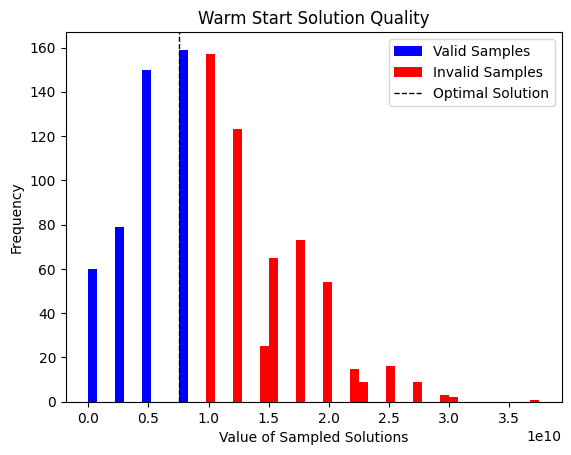

In [84]:
# Pick k = 10 since it gives a gives a good balance between the uniform and lazy greedy distributions.
k = 1
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples = 1000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approxmation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title('Warm Start Solution Quality')
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approxmation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an identical ratio we use weight as a tiebreaker.

In [85]:
warm_start_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]
ordered_weights = weights[qubit_order]
ordered_values = values[qubit_order]
ordered_ratios = ratios[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)


Let's obtain the Gurobi solution for this new ordering

Knapsack Capacity: 9975266561.564
Total Value of optimal solution: 7500305194
Total Weight of optimal solution: 7500304969
Runtime: 0.007092 seconds


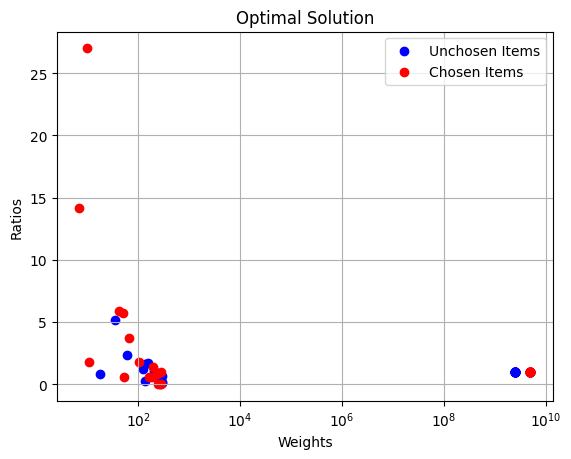

In [86]:
result_gurobi = gurobi_knapsack_solver(ordered_values, ordered_weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer. This mixer takes as input variabels $\theta, p_1,$ and $p_2$, in addition to a parameter $\beta$ which controls the mixer strength as in standard QAOA. To explain this mixer, we first define the *Copula Distribution* $p_{cop}$ to be a distribution over two bits with: 

$$
\begin{align}
p_{cop}(0,0) &= (1 - p_1)(1-p_2) + \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(0,1) &= (1 - p_1)(p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,0) &= (p_1)(1-p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,1) &= (p_1)(p_2) + \theta p_1 p_2(1 - p_1)(1-p_2)
\end{align}
$$

Straightforward computation shows that this distribution has single-bit marginal probabilities matching the proabilities $p_1$ and $p_2$ used in its definition. The $\theta$ parameter takes values in $[-1,1]$ and controls whether the two bits are correlated or anti-correlated in this distribution. When $\theta = -1$ bits are maximally anti-correlated, and $\theta = 1$ corresponds to bits being maximally correlated.  

Now we construct a unitary $R_{cop}$ satisfying $R_{cop}\ket{00} = \ket{p_{cop}}$ and define the mixer Hamiltoniaon $H_{cop} = -R_{cop}^\dagger (ZZ) R_{cop}$. Then the state $\ket{p_{cop}} = \sum_{x_1, x_2} \sqrt{p_{cop}(x_1,x_2)} \ket{x_1, x_2}$ is the ground state of the Hamiltonian with eigenvalue $-2$, and all other eigenstates have eigenvalue $\geq 0$. Finally, the Copula mixer in terms of $\beta$ is defined by 

$$
\begin{align}
U_{cop, \beta} = \exp(-i \beta H_{cop}).
\end{align}
$$

Note that setting $\beta = 0$ turns off the Copula mixer. Since the eigenvalues of $H_{cop}$ are multiples of two, **the mixer is period in $\beta$ with a periodicity of $\pi$**, i.e. we have $U_{cop, \ \beta} = U_{cop,\ \beta + \pi}$ for any $\beta$. 

In [87]:
def construct_cop(p_1, p_2, beta, theta = -1):
    """
    Constructs a two qubit copula mixer with the given parameters.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum on which we add the Copula mixer.
        p_1 (float): Probability p_1 in the definition of the copula mixer.
        p_2 (float): Probability p_2 in the definition of the copula mixer.
        beta (float): The strength of the copula mixer.
        theta (float): The theta parameter of the copula mixer, which controls whether qubits are correlated or anti-correlated. Should take values in [-1,1] and defaults to -1, which means maximum anticorrelation.

    Returns:
        QuantumCircuit: The quantum circuit with the copula mixer added.
    """

    # We first construct a rotation operator designed to rotate the |00> state to the |p_cop> state.
    rotation_circuit = QuantumCircuit(2)
    phi_1 = 2 * np.arcsin(np.sqrt(p_1))  
    p_2_given_1 = (p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2))/ p_1
    phi_2_given_1 = 2 * np.arcsin(np.sqrt(p_2_given_1))
    p_2_given_not1 = ((1- p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)) / (1 - p_1)
    phi_2_given_not1 = 2 * np.arcsin(np.sqrt(p_2_given_not1))

    rotation_circuit.ry(phi_1, 0)  # Rotate first qubit to the correct marginal distribution
    rotation_circuit.cry(phi_2_given_1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |1>
    rotation_circuit.x(0)  # Flip qubit 1
    rotation_circuit.cry(phi_2_given_not1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |0>
    rotation_circuit.x(0)  # Undo flip

    copula_mixer = QuantumCircuit(2)
    copula_mixer.compose(rotation_circuit.inverse(), inplace=True) # rotate |p_cop> to |00>
    copula_mixer.barrier()  
    # In this rotated basis, the copula mixer is diagonal, so we can impliment with RZ gates.
    copula_mixer.rz(-2* beta, 0)  
    copula_mixer.rz(-2 *beta, 1)  
    copula_mixer.barrier()  
    copula_mixer.compose(rotation_circuit, inplace=True) # rotate |00> back to |p_cop>

    return copula_mixer
    

Now lets run some basic tests to verify the copula is working as intended. 

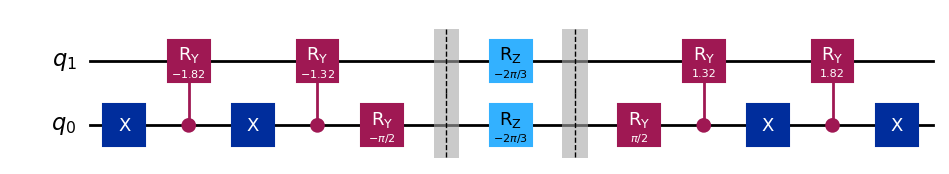

Eigenvalues of the copula mixer: 

Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.7071-0.0000j |00>  + 0.0000+0.0000j |01> + -0.0000-0.0000j |10> + 0.7071+0.0000j |11>
Eigenvalue: -0.5000-0.8660j
Eigenvector: 0.5590+0.0000j |00>  + -0.4330+0.0000j |01> + -0.4330-0.0000j |10> + 0.5590+0.0000j |11>
Eigenvalue: -0.5000+0.8660j
Eigenvector: 0.4330+0.0000j |00>  + 0.5590+0.0000j |01> + 0.5590+0.0000j |10> + 0.4330-0.0000j |11>
Eigenvalue: 1.0000-0.0000j
Eigenvector: 0.2963+0.1538j |00>  + 0.6233+0.0000j |01> + -0.6233-0.0000j |10> + -0.2963-0.1538j |11>

We expect an eigenvector: 0.4330 |00> + 0.5590 |01> + 0.5590 |10> + 0.4330 |11>
with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = -0.5000+0.8660j


In [88]:
from qiskit.quantum_info import Operator 

# Test the copula mixer construction.
test_copula_mixer = construct_cop(0.5, 0.5, np.pi/3)

display(test_copula_mixer.draw('mpl', scale=1, idle_wires=False, fold=-1, reverse_bits=True))

# This unitary is small enough we can just check its eigenvectors and eigenvalues directly. 
cop_unitary = Operator(test_copula_mixer).data
eigenvalues, eigenvectors = np.linalg.eig(cop_unitary)

print("Eigenvalues of the copula mixer: \n")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue: {ev:.4f}")
    print(f"Eigenvector: {eigenvectors[0,i]:.4f} |00>  + {eigenvectors[1,i]:.4f} |01> + {eigenvectors[2,i]:.4f} |10> + {eigenvectors[3,i]:.4f} |11>")  


p_1 = 0.5
p_2 = 0.5
theta = -1
p_cop_00 = (1 - p_1) * (1 - p_2) + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_01 = (1 - p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_10 = p_1 * (1 - p_2) - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_11 = p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)

print(f"\nWe expect an eigenvector: {np.sqrt(p_cop_00):.4f} |00> + {np.sqrt(p_cop_01):.4f} |01> + {np.sqrt(p_cop_10):.4f} |10> + {np.sqrt(p_cop_11):.4f} |11>")
print(f"with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = {np.exp(2j * np.pi / 3):.4f}")


Now we can construct the "ring" copula mixer proposed in https://arxiv.org/pdf/2108.08805. The idea is to visualize the qubits as lying in a ring, and to apply the two qubit copula mixer defined above between nearest neighbour terms on the ring. We get the probabilities $p_i$ and $p_j$ used in the defintion of each copula mixer from the warm start distribution we used to initialize our quantum state. 

This should have the effect of leaving the qubits with high ratios of value-to-weight as very likely in the knapsack, and the low ratio qubits as very likely excluded from the knapsack, but it will encourage mixing between the qubits with middling value. This mixing should anti-correlate nearby terms -- adding an item to the knapsack while removing an item with similar ratio -- and thus approximately preserve the overall knapsack weight.

In [89]:
def add_ring_copula(quantum_circuit, probability_dist, beta):
    """
    Constructs a ring copula mixer on the given quantum circuit.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the ring copula mixer.
        probability_dist (np.ndarray): The probability distribution to use for the copula mixer.
    """
    n = len(probability_dist)
    for i in range(1,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    for i in range(2,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    quantum_circuit.barrier()  
    return quantum_circuit

To complete the setup for xQAOA we also need to define a cost function. Because we have encoded a (soft) version of our constraints into our mixer we leave constraints out of this cost function. But then it is particularly straightfoward -- we simply sum the values of each of the items included in the knapsack. 

As in standard QAOA we also multiple our cost function by a $\gamma$ parameter. Because we want this parameter to take values in $[0,2\pi]$, we will normalize all our values by the max possible value so the normalized values lie in $[0,1]$. 

In [90]:
def add_knapsack_cost_function(quantum_circuit, values, gamma):
    """
    Adds a cost function to the quantum circuit that sums the values of the items included in the knapsack.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the cost function.
        values (np.ndarray): The values of the items in the knapsack.
        gamma (float): The strength of the cost function.
    """

    max_value = np.max(values)
    n = len(values) 
    for i in range(n):
        quantum_circuit.p(gamma * values[i]/max_value, i)  # Apply RZ gate with angle proportional to value
    quantum_circuit.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

Finally, we can put this all together and visualize the circuit with the warm start initialization, one layer of the cost unitary, and one layer of the mixer. 

In [91]:
# Now lets plot a sample of our circuit with one layer of the ring copula mixer. 
# Picking arbitrary values of beta and gamma for now.
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, ordered_values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)
#qc.draw("mpl",fold=-1, idle_wires=False)

Let's also define a class that will be useful for computing expectation values below.

Let's now use the lightcome estimator defined previously to compute the objective function achieved in expectation by the output distribution of a quantum circuit. We perform some sanity checks, then compute the performance of the depth one xQAOA mixer for some arbitrary values of $\gamma$ and $\beta$.

### Train for beta and gamma and compare warm start, random distribution, and xQAOA

#### Simulation setup

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import Parameter

backend = QiskitRuntimeService(name='pinq').backend('ibm_quebec')
optimization_level=3
pm = generate_preset_pass_manager(backend=backend, optimization_level = optimization_level)
nm = None
coupling_map = backend.configuration().coupling_map
basis_gates = backend.basis_gates

# initialize noisy simulator
estimator_mps = EstimatorV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                               })

sampler_mps = SamplerV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                                 })

Let's try a sampler based optimization. This is quicker than the estimator based optimization

In [94]:
# Sampler based optimization
from scripts.utils.kp_utils import get_weight, get_value
from qiskit import transpile



def sampler_based_optimizer(qc, capacity, shots=10_000):
    qc = transpile(qc, basis_gates = backend.basis_gates)
    qc.measure_all()
    job = sampler_mps.run([(qc,)], shots=shots)
    sampler_result = job.result()
    sampled_counts = sampler_result[0].data.meas.get_counts() 
    shots = sum(sampled_counts.values())
    filtered_bitstrings= []
    filtered_cost_values = []
    for key in sampled_counts.keys():
        if get_weight(key[::-1], ordered_weights) <= capacity:
            filtered_bitstrings.append(key)
            filtered_cost_values.append(get_value(key[::-1], ordered_values) * sampled_counts[key]/shots)
        else: 
            continue
    filtered_distribution = {
        key: val / shots for key, val in sampled_counts.items() if key in filtered_bitstrings
    }
    filtered_exp_val = sum(filtered_cost_values)

    return filtered_distribution, filtered_exp_val

In [95]:
from scipy.optimize import minimize

layers=5
max_iter=4
params=[]
shots=10_000

gammas = [Parameter(f"gamma_{i}") for i in range(layers)]
betas = [Parameter(f"beta_{i}") for i in range(layers)]

def cost_to_minimize(params:list, qc:QuantumCircuit):
    circ = qc.copy()
    circ.assign_parameters(params, inplace=True)
    _,cost = sampler_based_optimizer(circ, capacity=capacity, shots=shots)
    return -cost

def __optimization_loop__(qc, max_iter=max_iter):
    x_vals= []
    y_vals = []
    for i in range(max_iter):
        for k in range(max_iter):
            init_params = [i*np.pi/(max_iter-1), 2*k*np.pi/(max_iter-1)]
            result_lc = minimize(
            cost_to_minimize,
            init_params,
            args=qc,
            method="COBYLA",
            bounds=[(0, np.pi), (0, 2*np.pi)],
            tol=1e-2,
            )
            print(result_lc)
            y_vals.append(cost_to_minimize(list(result_lc.x),qc))
            x_vals.append((result_lc.x))
    
    min_params=x_vals[np.argmin(y_vals)]
    return min_params

qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
circuits_at_different_p=[]
with tqdm(total=layers) as pbar:
    for p in range(layers):
            qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[p])
            qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[p])
            min_params = __optimization_loop__(qc)
            params.append((min_params))
            qc.assign_parameters(min_params,inplace=True)
            circuits_at_different_p.append(qc.copy())
            pbar.update(1)
    



  0%|          | 0/5 [00:00<?, ?it/s]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2200316100.1482005
       x: [ 0.000e+00  0.000e+00]
    nfev: 15
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2225318790.2268996
       x: [ 1.585e-02  3.861e+00]
    nfev: 23
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2724849918.4608006
       x: [ 9.868e-02  4.673e+00]
    nfev: 25
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2145564574.935402
       x: [ 9.827e-20  6.273e+00]
    nfev: 17
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2677835263.3376927
       x: [ 1.355e+00  5.279e-01]
    nfev: 21
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2285817580.420602
       x: [ 1.479e+00  1.871e+00]
    nfev: 18
   maxcv: 0.0
 messa

 20%|██        | 1/5 [04:04<16:19, 244.94s/it]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2726334935.9167
       x: [ 2.470e-02  9.833e-01]
    nfev: 22
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3422887495.589701
       x: [ 1.526e-01  4.142e+00]
    nfev: 24
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3413386755.8838086
       x: [ 1.315e-01  4.292e+00]
    nfev: 21
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2736836659.086098
       x: [ 0.000e+00  6.283e+00]
    nfev: 7
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2770336110.334585
       x: [ 2.501e-02 -8.674e-19]
    nfev: 18
   maxcv: 8.673617379884035e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2755587196.312097
       x: [-1.233e-32  1.350e-01]
    nfev: 21
   maxcv

 40%|████      | 2/5 [09:22<14:22, 287.62s/it]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3443637951.209797
       x: [-2.584e-19  9.275e-01]
    nfev: 20
   maxcv: 2.584407821605425e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3467388894.9701915
       x: [-2.322e-19  3.084e+00]
    nfev: 17
   maxcv: 2.3216608597899333e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3436887640.023807
       x: [ 5.567e-03  5.322e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3479139446.8663974
       x: [ 0.000e+00  6.283e+00]
    nfev: 15
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3519641590.636908
       x: [ 1.410e-02  9.983e-02]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3482639371.5059977
       x: [-2.216e-17 -5.551e-1

 60%|██████    | 3/5 [15:14<10:34, 317.24s/it]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3469139551.969603
       x: [ 2.018e-20  2.010e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3503640590.419511
       x: [ 1.000e-02  3.219e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3474389830.6424904
       x: [-2.190e-19  3.261e+00]
    nfev: 21
   maxcv: 2.1904500737350295e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3461389491.7927957
       x: [ 7.283e-03  5.776e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3481390222.161001
       x: [ 9.933e-03  5.012e-01]
    nfev: 22
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3483640208.6934013
       x: [ 0.000e+00  4.369e-01]
    nfev: 19
  

 80%|████████  | 4/5 [21:48<05:47, 347.37s/it]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3499640813.771403
       x: [ 0.000e+00  0.000e+00]
    nfev: 15
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3461389359.502605
       x: [ 9.916e-03  3.583e+00]
    nfev: 21
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3518891738.8999944
       x: [ 6.255e-03  5.228e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3442138594.5691996
       x: [-4.928e-19  6.246e+00]
    nfev: 14
   maxcv: 4.928440751749672e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3474139876.63129
       x: [ 0.000e+00  0.000e+00]
    nfev: 14
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2705856709.372003
       x: [ 1.578e+00  2.988e+00]
    nfev: 19
   ma

100%|██████████| 5/5 [27:54<00:00, 334.83s/it]


In [243]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import timeline_drawer
cir = QuantumCircuit(1, 1)
cir.z(0)
cir.rz(1.44,0)
cir.measure(0, 0)
xp = pm.run(cir)
timeline = timeline_drawer(xp, target=backend.target, idle_wires=False)




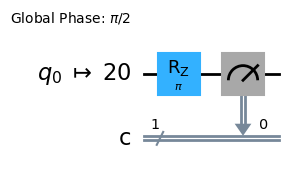

In [244]:
xp.draw("mpl", idle_wires=False)

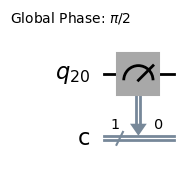

In [245]:
from qiskit.transpiler.passes import RemoveDiagonalGatesBeforeMeasure
from qiskit.converters import circuit_to_dag, dag_to_circuit

rdgm = RemoveDiagonalGatesBeforeMeasure()

dag_to_circuit(rdgm.run(circuit_to_dag(xp))).draw("mpl", idle_wires=False)

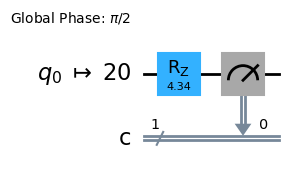

In [238]:
xp.draw("mpl", idle_wires=False)

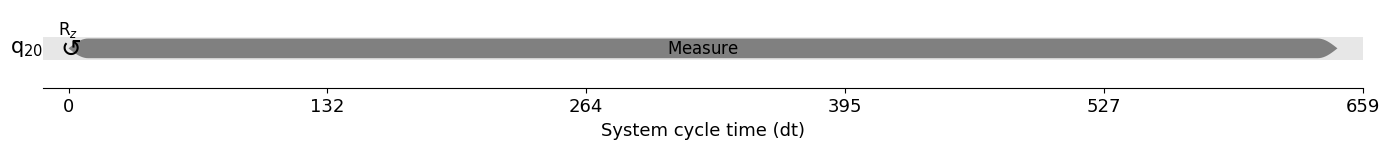

In [239]:
timeline

In [96]:
print(f'Depth of p=5 qaoa circuit: {qc.depth(lambda x: len(x.qubits)==2)}')

Depth of p=5 qaoa circuit: 60


In [97]:
print(f'Optimal parameters at different values of p: {params}')

Optimal parameters at different values of p: [array([2.99862057, 0.69248334]), array([0.13154277, 4.29244561]), array([0.01409595, 0.0998307 ]), array([3.13346043, 2.08857557]), array([3.12159265, 6.28318531])]


In [159]:
def compute_approximate_ratio(dict_bit_values, value_opt):
    # Compute the approximate ratio
    total = 0
    tot_counts = 0
    for values, counts in dict_bit_values.items():
        tot_counts +=counts
        if tot_counts<= 46430:
            total += values * counts
        else:
            tot_counts -=counts
            break

    # sum all the counts in the histogram of valid solutions
    # total_valid_shots = sum(dict_bit_values.values())
    # norm_aprox_ratio = total / (total_valid_shots * value_opt)
    norm_aprox_ratio = total / (46430 * value_opt)

    return norm_aprox_ratio, tot_counts

Recalculating the distribution from xQAOA using the sampler based optimizer defined above

In [160]:
filter_sols = True
dict_bit_values_at_different_p  = {}
pubs = []
shots = 100000

for circ in circuits_at_different_p:
    xp_circ = pm.run(circ)
    xp_circ.measure_active()
    pubs.append(xp_circ)

job = sampler_mps.run(pubs, shots=shots)   
for i in range(layers):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]


    dict_bit_values_qaoa = convert_bitstring_to_values(counts_bin_qc_rev, ordered_values, ordered_weights, capacity,
                                            filter_invalid_solutions=filter_sols)

    #Sort the dictionary by value
    sorted_dict = dict(sorted(dict_bit_values_qaoa.items(), key=lambda item: item[0], reverse=True))
    dict_bit_values_at_different_p[f"p = {i}"] = sorted_dict
    best_value = max(sorted_dict.keys())
    best_count = sorted_dict[best_value]
    print(f"Best value: {best_value}")

    # norm_approx_ratio_qaoa, valid_shots_qaoa = compute_approximate_ratio(dict_bit_values_qaoa, optimal_value)

    norm_approx_ratio_qaoa, valid_shots_qaoa = compute_approximate_ratio(sorted_dict, optimal_value)

    print(f'(Normalized) approximate ratio: {norm_approx_ratio_qaoa}', '\n' 
        f'Number of valid shots: {valid_shots_qaoa}')

Processing bitstrings: 100%|██████████| 60853/60853 [00:00<00:00, 64182.52it/s]


Best value: 7500302500
(Normalized) approximate ratio: 0.7015201315341398 
Number of valid shots: 46426


Processing bitstrings: 100%|██████████| 70653/70653 [00:01<00:00, 69440.64it/s]


Best value: 7500302774
(Normalized) approximate ratio: 0.6964018524216975 
Number of valid shots: 46426


Processing bitstrings: 100%|██████████| 73590/73590 [00:01<00:00, 72640.43it/s]


Best value: 7500302794
(Normalized) approximate ratio: 0.6796529319151549 
Number of valid shots: 46425


Processing bitstrings: 100%|██████████| 72832/72832 [00:01<00:00, 71685.19it/s]


Best value: 7500302479
(Normalized) approximate ratio: 0.6852023866997714 
Number of valid shots: 46401


Processing bitstrings: 100%|██████████| 74386/74386 [00:01<00:00, 72919.66it/s]

Best value: 7500302613
(Normalized) approximate ratio: 0.6754962431531967 
Number of valid shots: 46430


In [162]:
warm_start_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in qubit_ordered_distribution)
    warm_start_counts[bitstring] += 1

dict_bit_values_ws = convert_bitstring_to_values(warm_start_counts, ordered_values, ordered_weights, capacity,
                                                   filter_invalid_solutions=filter_sols)

# Compute the probability of sucess
p_sucess_ws= probabilty_success(dict_bit_values_ws, optimal_value)
norm_approx_ratio_ws, valid_shots_ws = compute_approximate_ratio(dict_bit_values_ws, optimal_value)
print(f"Best WS value: {max(dict_bit_values_ws.keys())}")
print(f"Normalized approximate ratio {norm_approx_ratio_ws}", '\n'
       f"Number of valid shots: {valid_shots_ws}")

Processing bitstrings: 100%|██████████| 84054/84054 [00:01<00:00, 80514.04it/s]

Best WS value: 7500302708
Normalized approximate ratio 0.61400744100825 
Number of valid shots: 46430


In [ ]:
Best WS value: 7500302711
Normalized approximate ratio 0.6176687985574758 
Number of valid shots: 46430

For p=1, let's also plot a heatmap of the cost function landscape

In [ ]:
beta_range = np.linspace(0, np.pi, 30)
gamma_range = np.linspace(0, 2 * np.pi, 30)
p=1
ev = np.array(np.zeros((len(beta_range), len(gamma_range))), dtype=float)

gammas = [Parameter(f"gamma_{i}") for i in range(p)]
betas = [Parameter(f"beta_{i}") for i in range(p)]
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

for layer in range(p):
     qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[layer])
     qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[layer])
     qc = transpile(qc, basis_gates=backend.basis_gates)


with tqdm(total=len(beta_range) * len(gamma_range), desc="Computing cost functions") as pbar:
    for i,j in np.ndindex(len(beta_range), len(gamma_range)):
        circ=qc.assign_parameters({qc.parameters[0]: beta_range[i], qc.parameters[1]:gamma_range[j]})
        _,ev[i][j] = sampler_based_optimizer(circ, capacity=capacity, shots=100000)
        pbar.update(1)



qc = QuantumCircuit(n)
_,cost_fn_min = sampler_based_optimizer(qc, capacity=capacity)
for i in range(n):
    if i in result_gurobi['selected_items']:
        qc.x(i)
_,cost_fn_max = sampler_based_optimizer(qc, capacity=capacity)

norm_ev = ((ev - cost_fn_min) / (cost_fn_max - cost_fn_min)).real

plt.imshow(norm_ev, origin='lower', aspect='auto', cmap='viridis', extent = (0, 2 * np.pi, 0, np.pi))

cbar = plt.colorbar()

cbar.set_label('Objective value')
plt.tight_layout(rect=(0.0, 0.05, 1.0, 1.0))

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title(f"xQAOA Normalised objective Function Landscape (p={p})")
plt.show()

Computing cost functions:  10%|▉         | 89/900 [1:10:39<11:48:32, 52.42s/it]

Now let's compare the full QAOA with Warm start

In [99]:
warm_start_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in qubit_ordered_distribution)
    warm_start_counts[bitstring] += 1

dict_bit_values_ws = convert_bitstring_to_values(warm_start_counts, ordered_values, ordered_weights, capacity,
                                                   filter_invalid_solutions=filter_sols)

# Compute the probability of sucess
p_sucess_ws= probabilty_success(dict_bit_values_ws, optimal_value)
norm_approx_ratio_ws, valid_shots_ws = compute_approximate_ratio(dict_bit_values_ws, optimal_value)
print(f"Best WS value: {max(dict_bit_values_ws.keys())}")
print(f"Normalized approximate ratio {norm_approx_ratio_ws}", '\n'
       f"Number of valid shots: {valid_shots_ws}")

Processing bitstrings: 100%|██████████| 84386/84386 [00:01<00:00, 74688.06it/s]

Best WS value: 7500302711
Normalized approximate ratio 0.6176687985574758 
Number of valid shots: 46430


Let's also add a random distribution as a point of comparison with full QAOA

In [100]:
random_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(x) for x in np.random.randint(2, size=n))
    random_counts[bitstring] += 1


dict_bit_values_random = convert_bitstring_to_values(random_counts, ordered_values, ordered_weights, capacity,
                                                     filter_invalid_solutions=filter_sols)

# Compute the probability of success
norm_approx_ratio_rand, valid_shots_rand = compute_approximate_ratio(dict_bit_values_random, optimal_value)
print(f"Best rand value: {max(dict_bit_values_random.keys())}")
print(f"(Normalized) Rand approx ratio {norm_approx_ratio_rand}",'\n'
       f"Number of valid shots {valid_shots_rand}")

Processing bitstrings: 100%|██████████| 100000/100000 [00:01<00:00, 97458.77it/s]

No valid solutions found!



/Users/ibrahimshehzad/unit_commitment/scripts/utils/kp_utils.py:501: RuntimeWarning: invalid value encountered in scalar divide
  norm_aprox_ratio = total / (total_valid_shots * value_opt)


ValueError: max() iterable argument is empty

Let's make a comparison plot of the various distributions

In [145]:
def plot_multiple_distributions(data_dict, min_cost=None, 
                           bins_width=50, log=True, output_file=None,
                           colors=None, labels=None, title=None, nb_bins=200,
                           annotations=None, figsize=(10, 6)):
    """
    Plots histograms of multiple distributions on the same plot with optional vertical line.
    
    Parameters:
    data_dict (dict): Dictionary where keys are method names and values are dictionaries 
                     with keys as data points and values as weights.
    min_cost (float, optional): The value at which to draw the vertical line.
    bins_width (int): Number of bins for the histograms.
    log (bool): Whether to use log scale for y-axis.
    output_file (str, optional): File path to save the plot (e.g., "output.png").
    colors (dict, optional): Dictionary mapping method names to colors.
    labels (dict, optional): Dictionary mapping method names to display labels.
    title (str, optional): Title for the plot.
    annotations (dict, optional): Dictionary with annotation text and position.
    figsize (tuple): Figure size (width, height).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Default colors if not provided
    default_colors = ['steelblue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive']
    
    if colors is None:
        colors = {method: default_colors[i % len(default_colors)] 
                 for i, method in enumerate(data_dict.keys())}
    
    if labels is None:
        labels = {method: method for method in data_dict.keys()}
    
    fig, ax = plt.subplots(figsize=figsize)
    max_height = 0
    
    # Find the global range for consistent binning
    all_values = []
    for method, data in data_dict.items():
        if data:  # Check if data exists
            all_values.extend(list(data.keys()))
    
    if not all_values:
        print("No data to plot")
        return
    
    # Create consistent bins across all distributions
    min_val = min(all_values)
    max_val = max(all_values)
    bin_edges = np.linspace(min_val, max_val, bins_width + 1)
    
    # Plot each distribution
    for i, (method, data) in enumerate(data_dict.items()):
        if not data:  # Skip if no data
            continue
            
        values = list(data.keys())
        weights = list(data.values())
        
        counts, _, patches = ax.hist(
            values,
            weights=weights,
            bins=nb_bins,
            edgecolor=colors[method],
            alpha=0.7,
            color=colors[method],
            label=labels[method],
            histtype='step'
        )
        
        current_max = max(counts) if len(counts) > 0 else 0
        max_height = max(max_height, current_max)
    
    # Add vertical line for optimal value if provided
    if min_cost is not None:
        ax.axvline(min_cost, linestyle="--", color="black", label="Optimal", linewidth=1.5)
    
    # Add annotations if provided
    if annotations:
        text = "\n".join([f"{k}: {v:.2f}" for k, v in annotations.items()])
        ax.text(
            0.05, 0.95, text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
        )
    
    # Set log scale for y-axis if requested
    if log:
        ax.set_yscale("log")
        ax.set_xscale("log")
    
    # Add labels, title, and legend
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_xlabel("Values", fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(fontsize=10, loc='best')
    ax.set_xlim((.75003e10, .750032e10))
    
    # Add gridlines for clarity
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    
    # Show or save plot
    if output_file:
        plt.savefig(output_file, bbox_inches="tight", dpi=300)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

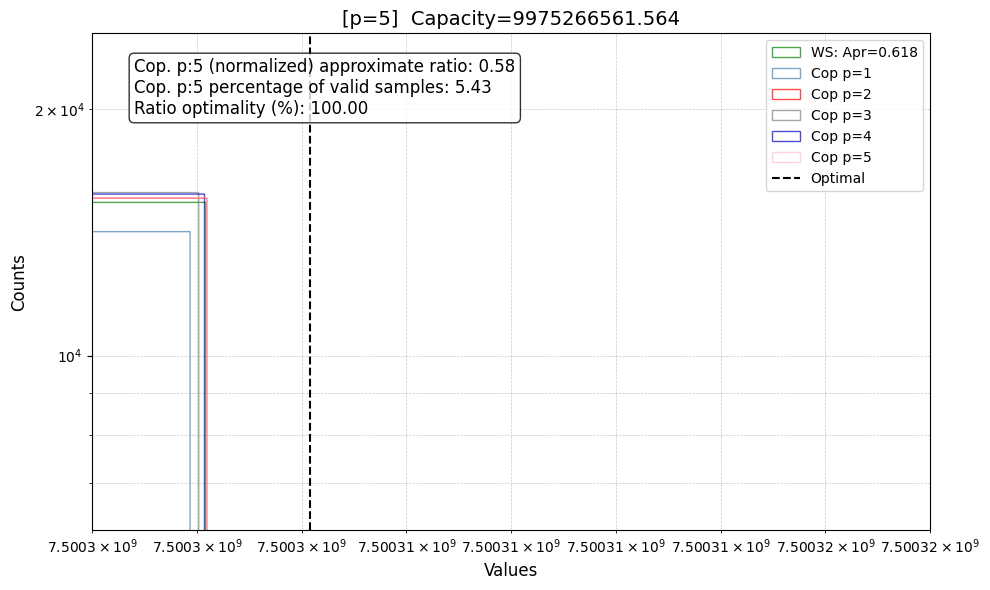

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': '[p=5]  Capacity=9975266561.564'}, xlabel='Values', ylabel='Counts'>)

In [146]:
#from scripts.utils.visualize import plot_multiple_distributions

data_dict = {
   # f"Random: Apr={norm_approx_ratio_rand:.2f}": dict_bit_values_random,
   f"WS: Apr={norm_approx_ratio_ws:.3f}": dict_bit_values_ws,
   f"Cop p={1}": dict_bit_values_at_different_p["p = 0"],
   f"Cop p={2}": dict_bit_values_at_different_p["p = 1"],
   f"Cop p={3}": dict_bit_values_at_different_p["p = 2"],
   f"Cop p={4}": dict_bit_values_at_different_p["p = 3"],
   f"Cop p={5}": dict_bit_values_at_different_p["p = 4"]
}
# Custom colors
colors = {
   # f"Random: Apr={norm_approx_ratio_rand:.2f}": "orange",
    f"WS: Apr={norm_approx_ratio_ws:.3f}": 'green',
    f"Cop p={1}": "steelblue",
    f"Cop p={2}": "red",
    f"Cop p={3}": "grey",
    f"Cop p={4}": "mediumblue",
    f"Cop p={5}": "pink"
}    
# Annotations
annotations = {
    f'Cop. p:{layers} (normalized) approximate ratio': np.round(norm_approx_ratio_qaoa, 2),
    f'Cop. p:{layers} percentage of valid samples': 100*(valid_shots_qaoa/1000000),
    "Ratio optimality (%)": np.round(best_value /optimal_value *100, 2),
}
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=2000,
    log=True,
    annotations=annotations,
    figsize=(10, 6),
    title=f"[p={layers}]  Capacity={capacity}"
)

In [ ]:
# def load_instance(file_path: str):
#     file_path = str(file_path)
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     n = int(lines[0].strip())  # Number of items
#     items = [tuple(map(int, line.strip().split())) for line in lines[1:n+1]]  # value, weight
#     capacity = int(lines[n+1].strip())  # Knapsack capacity

#     values = [v for v, w in items]
#     weights = [w for v, w in items]

#     return {
#         "file": file_path,
#         "num_items": n,
#         "values": values,
#         "weights": weights,
#         "capacity": capacity
#     }
# def load_first_n_nap_instances(folder_path: str, n: int = 10):
#     folder = Path(folder_path)
#     # Get all .NAP files (case-sensitive); use case-insensitive match if needed
#     instance_files = list(folder.glob("*.knap"))[:n]

#     instances = []
#     for file_path in instance_files:
#         instance = load_instance(file_path)
#         instances.append(instance)

#     return instances
# instances = load_first_n_nap_instances(real_dataset_name="Hard", num_hard_instances)
# instance = instances[instance_index]
# n = instance['num_items']
# print('number of item',n)
# weights = np.array(instance['weights'])
# values = np.array(instance['values'])
#        # print('weights',weights)
# capacity = np.array(instance['capacity'])
# frac = capacity / np.sum(weights)

### Set up hardware run

The `ordered_values` that this experiment will correspond to

In [34]:
ordered_values

array([346.94931605, 346.92786056, 312.90989548, 484.84826306,
       433.83714147, 456.82344913, 445.81679186, 310.86604195,
       324.70631621, 411.61988091, 493.52667947, 434.53428659,
       415.54563788, 447.48550065, 430.48519589, 471.3183337 ,
       394.36136773, 414.32539259, 330.41553065, 493.12434366,
       299.44968777, 320.36673215, 336.31845077, 490.98911313,
       367.24303516, 442.08385598, 389.1925224 , 321.3026778 ,
       395.9251454 , 358.99743553, 403.81893985, 374.90164109,
       321.04005085, 480.55997302, 379.68329894, 455.38728698,
       463.28941417, 419.39235584, 354.63134032, 398.37241994,
       419.26091725, 457.07883202, 309.63673991, 348.43502454,
       433.01839553, 445.89042553, 455.82320418, 476.68309965,
       308.49071895, 323.41722643, 444.77350879, 392.95459584,
       314.35110275, 306.36460262, 470.44397819, 367.95958975,
       319.19357186, 370.8739276 , 366.86975502, 449.38541708,
       431.41039566, 373.71021054, 340.834943  , 456.10

The `ordered_weights` that this run will correspond to

In [35]:
ordered_weights

array([347, 347, 313, 485, 434, 457, 446, 311, 325, 412, 494, 435, 416,
       448, 431, 472, 395, 415, 331, 494, 300, 321, 337, 492, 368, 443,
       390, 322, 397, 360, 405, 376, 322, 482, 381, 457, 465, 421, 356,
       400, 421, 459, 311, 350, 435, 448, 458, 479, 310, 325, 447, 395,
       316, 308, 473, 370, 321, 373, 369, 452, 434, 376, 343, 459, 343,
       355, 330, 388, 332, 376, 389, 431, 411, 441, 426, 453, 311, 376,
       385, 431, 330, 310, 344, 387, 388, 474, 421, 428, 410, 309, 433,
       373, 334, 458, 405, 430, 321, 328, 399, 307])

Load the circuits that were used in simulations and setup pubs for hardware

In [50]:
import pickle

hardware_pubs=[]
for i in range(layers):
    filename = f"hardware_circs/hardware_qaoa_p{i+1}.pkl"
    with open(filename, 'rb') as file:
        loaded_qc = pickle.load(file)
        hardware_pubs.append(loaded_qc)

Submit jobs to backend

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

SHOTS = 1000000
service = QiskitRuntimeService()
backend = service.backend('ibm_quebec')

sampler = SamplerV2(mode=backend)
sampler.options.default_shots = SHOTS
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'
sampler.options.twirling.enable_gates = True
sampler.options.twirling.enable_measure = True
sampler.options.twirling.strategy="active-circuit"

hw_job = sampler.run(hardware_pubs)   


Retrieve jobs and analyze

In [ ]:
filter_sols = True
hw_dict_bit_values_at_different_p  = {}

for i in range(layers):
    counts_bin_qc = hw_job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]


    hw_dict_bit_values_qaoa = convert_bitstring_to_values(counts_bin_qc_rev, ordered_values, ordered_weights, capacity,
                                            filter_invalid_solutions=filter_sols)

    #Sort the dictionary by value
    sorted_dict = dict(sorted(hw_dict_bit_values_qaoa.items(), key=lambda item: item[0], reverse=True))
    hw_dict_bit_values_at_different_p[f"p = {i}"] = sorted_dict
    best_value = max(sorted_dict.keys())
    best_count = sorted_dict[best_value]
    print(f"Best value: {best_value}")

    hw_norm_approx_ratio_qaoa, hw_valid_shots_qaoa = compute_approximate_ratio(hw_dict_bit_values_qaoa, optimal_value)

    print(f'(Normalized) approximate ratio: {hw_norm_approx_ratio_qaoa}', '\n' 
        f'Number of valid shots: {hw_valid_shots_qaoa}')

Plots for comparison

In [ ]:
from scripts.utils.visualize import plot_multiple_distributions

data_dict = {
    f"Random: Apr={norm_approx_ratio_rand:.2f}": dict_bit_values_random,
   f"WS: Apr={norm_approx_ratio_ws:.3f}": dict_bit_values_ws,
   f"Cop p={1}": hw_dict_bit_values_at_different_p["p = 0"],
   f"Cop p={2}": hw_dict_bit_values_at_different_p["p = 1"],
   f"Cop p={3}": hw_dict_bit_values_at_different_p["p = 2"],
   f"Cop p={4}": hw_dict_bit_values_at_different_p["p = 3"],
   f"Cop p={5}": hw_dict_bit_values_at_different_p["p = 4"]
}
# Custom colors
colors = {
    f"Random: Apr={norm_approx_ratio_rand:.2f}": "orange",
    f"WS: Apr={norm_approx_ratio_ws:.3f}": 'black',
    f"Cop p={1}": "steelblue",
    f"Cop p={2}": "red",
    f"Cop p={3}": "grey",
    f"Cop p={4}": "mediumblue",
    f"Cop p={5}": "brown"
}    
# Annotations
annotations = {
    f'Cop. p:{layers} (normalized) approximate ratio': np.round(norm_approx_ratio_qaoa, 2),
    f'Cop. p:{layers} percentage of valid samples': 100*(valid_shots_qaoa/1000000),
    "Ratio optimality (%)": np.round(best_value /optimal_value *100, 2),
}
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=2000,
    log=False,
    annotations=annotations,
    figsize=(10, 6),
    title=f"[p={layers}]  Capacity={capacity}"
)

Thought: Should we run warm start on hardware as well, just as a point of comparison?